In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
NCLASSES = 2
HEIGHT = 70
WIDTH = 70
NUM_CHANNELS = 3
BATCH_SIZE = 32

DATA_SET_COUNT = 27558
TEST_SET_COUNT = (DATA_SET_COUNT)*0.2
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.6
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
print(TEST_SET_COUNT,TRAIN_SET_COUNT, VAL_SET_COUNT)

5511.6 16534.8 5511.6


Auxiliary function for loading the dataset

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Load the dataset, replace the path with your own location of the dataset

In [4]:
data_dir = pathlib.Path('C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images')
#data_dir = pathlib.Path(r'C:\Users\Nuno\Desktop\trabalhoAA2\input\cell_images')

classNames = np.array(os.listdir(data_dir))
classNames

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images/*/*.png")
#listset = tf.data.Dataset.list_files(r"C:\Users\Nuno\Desktop\trabalhoAA2\input\cell_images\*\*.png")

dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


Data Augmentation

In [5]:
import random

#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    delta = tf.random.uniform(shape=(), minval=0.01, maxval=1) * 0.5
    lower_saturation = 0.9 + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.2
    upper_saturation = lower_saturation + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.2
    lower_value = 0.9 + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.3
    upper_value = lower_value + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.4
    image = tfa.image.random_hsv_in_yiq(image, 0.3, 0.8, 1.1, 0.9, 1.3)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    image = tf.clip_by_value(tf.image.adjust_brightness(image, -0.2),0,1)
    return image, label

def rotate_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=360)
    image = tfa.image.rotate(image, r)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def translate_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=1) * 14 - 7
    ry = tf.random.uniform(shape=(), minval=0, maxval=1) * 14 - 7
    image = tfa.image.translate(image, [rx, ry])
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def increase_contrast_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    image=tf.image.adjust_contrast(image,2)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def decrease_contrast_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    image=tf.image.adjust_contrast(image,0.6)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

Split the dataset into training, validation and tedt sets

In [6]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.repeat()

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
test_size= int(TEST_SET_COUNT)

train_dataset = dataset.take(train_size)
#-Data Augmentation
d1= train_dataset.map(increase_contrast_image,num_parallel_calls=AUTOTUNE)
d2= train_dataset.map(rotate_image,num_parallel_calls=AUTOTUNE)

NUM_MAPS_DATA_AUGMENT=3
train_size=train_size*NUM_MAPS_DATA_AUGMENT

train_dataset=train_dataset.concatenate(d1)
train_dataset=train_dataset.concatenate(d2)
#----
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.repeat();

test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)
test_dataset = test_dataset.shuffle(buffer_size = train_size)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset.skip(train_size+test_size)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat();


Load the test set

In [7]:
testset = test_dataset


- Todos os treinos feitos são feitos com as imagens todas com tamanho 50x50 de modo a tornar o input igual para todas elas.
- Primeiros resultados com 30 epocas:

    Rede: learning rate - 0.001
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(256)
        Dense(128)
    
    Resultados -> [0.09822106476054887, 0.9724188]
    
    Resultados -> [0.09970240995915057, 0.9771366]
    
    Resultados -> [0.09709152765370195, 0.97913265]


- OS graficos do treino tem muitos altos e baixos. vou tentar reduzir a learning rate de 0.001 para 0.0005 aver se ajuda.

    Com o número de epocas a 30 não é possivel ver uma melhoria continua dos resultados, por isso, decidiu-se diminuir esse número para as 20, visto que parece ser necessário para chegar a bons resultados.

    
    Resultados -> [0.07556610100638832, 0.97913265]
    
    Resultados -> [0.11845710180743398, 0.97822535]
    
    Resultados -> [0.11034344812033152, 0.9831247]
    
    Estas alterações parecem ter dados melhores resultados, assim, este modelo vai se manter e qualquer alteração será feita no mesmo.

- Agora vou experimentar aumentar a complexidade da rede depois do flatten.
    Rede: learning rate - 0.0005
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.11262756224884517, 0.97749954]

    Resultados -> [0.112837254023314, 0.9825803]

    Resultados -> [0.1579071757994804, 0.9818545]

- Não é possivel perceber se o ultimo passo melhorou ou não. Vou mander a rede anterior e aumentar a complexidade das camadas conv2d a ver o que acontece. Ficou 256 128 64

    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.09519005841656314, 0.97913265]

    Resultados -> [0.1559975825278033, 0.979677]

    Resultados -> [0.12951020138670086, 0.9833061]

    Decidi correr mais uma vez para ter uma ideia melhor de qual a média de resultados.

    Resultados -> [0.13078563809401567, 0.97659224]

    Resultados -> [0.10909477567710346, 0.9840319]

    Resultados -> [0.1473225694302675, 0.9825803]
    
    Parece que com este modelo conseguimos os melhores resultados até agora. Por isso vamos Manter o mesmo

- Vou fazer data augmentation para ver se melhora os resultados.
    Dupliquei o tamanho do dataset, usando uma função para rodar as imagens, e outra para aumentar o contraste. Assim força a rede a ignorar a orientação das celulas e força a rede a focar-se na diferença de cores entre infetada e nao infetada.
    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.1550383184648878, 0.95717657]

    Resultados -> [0.11947062133536862, 0.9664308]

    Resultados -> [0.1277277860857783, 0.96842676]

- Os resultados ficaram bastane piores por isso vou tentar apenas com um dos maps de cada vez. Primeiro vou tentar com o aumentar contrast.
    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.20363568402073115, 0.93776083]

    Resultados -> [0.24657452397038884, 0.9609871]

    Resultados -> [0.2891723330340764, 0.9468336]

- Mais uma vez, ficou ainda pior. Agora vou testar com o de rodar as imagens.
    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.23375302097542114, 0.96407187]

    Resultados -> [0.4722976528172342, 0.95481765]

    Resultados -> [0.5312820033113527, 0.9499183]

    Tanto o rotation, como o aumentar contraste poe os resultados piores.

- Como uma ultima tentativa de usar data sugmentation vou testar com os 3 juntos a ver (Aumentar contraste rodar e as imagens normais).
    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)

    Resultados -> [0.08983509639221529, 0.9695155]

    Resltados -> [0.06904044048322332, 0.9804028]

    Resultados -> [0.05812383999219003, 0.9849392]
    
    Nesta ultima situação não é possivel ver nenhuma melhoria e o treino ficou muito mais lento devito a termos um dataset 3 vezes maior que o original. Deste modo, vai se abandonar o data augmentation visto que nao melhora os resultados e visto também que temos um dataset bastante grande.
    
    Rede: learning rate - 0.0005
        conv2d(256)
        conv2d(128)
        conv2d(64)
        flattten()
        Dense(512)
        Dense(256)
        Dense(128)
        
- Ao longo de todo o processo de treinamento da rede existem zonas de dropout e maxpooling que não estão referidas nos modelos. Com isto podemos ter um modelo mais detalhado aqui:
    Rede: learning rate - 0.0005
        conv2d(256)
        dropout(0.3)
        conv2d(128)
        maxpooling(2,2)
        dropout(0.3)
        conv2d(64)
        maxpooling(2,2)
        dropout(0.3)
        flattten()
        Dense(512)
        Dropout(0.3)
        Dense(256)
        Dense(128)
    O dropout e o maxpooling sempre estiveram presentes desde o inicio da rede, mas para manter o modelo mais simples de escrever decidiu omitir-se dos modelos acima escritos mencionando apenas agora.
    
- Depois de alguns testes feitos(40x40, 30x30, 100x100) chegamos a um tamanho de imagens que parece dar melhores resultados que os 50x50. Juntamente com esta alteração de tamanhos alterou-se também a rede depois do flatten() ficando assim:
    Rede: learning rate - 0.0005
        conv2d(256)
        dropout(0.3)
        conv2d(128)
        maxpooling(2,2)
        dropout(0.3)
        conv2d(64)
        maxpooling(2,2)
        dropout(0.3)
        flattten()
        Dense(128)
        Dropout(0.3)
        Dense(64)
        
    
    Resultados -> [0.09002264992823836, 0.9700599]
    Resultados -> [0.06715019416862109, 0.9847578]
    Resultados -> [0.03985877299238524, 0.9891127]
        
- Agora vai ser feito uma função para optimizar hiper parametros, como o dropout e o learning rate.
    
    Resultado ([0.3, 0.3, 0.3, 0.3], 0.0005) ->[0.08301462591598834, 0.9707857]
    
    Resultado ([0.3, 0.3, 0.3, 0.3], 0.001) ->[0.09891370363598097, 0.96842676]
    
    Resultado ([0.3, 0.3, 0.3, 0.3], 0.002) ->[0.6930431999223081, 0.50807476]
    
    Resultado ([0.3, 0.3, 0.3, 0.3], 0.00025) ->[0.08059742877453652, 0.9727817]
    
    Resultado ([0.4, 0.4, 0.4, 0.4], 0.0005) ->[0.10650778054717304, 0.96770096]
    
    Resultado ([0.4, 0.4, 0.4, 0.4], 0.001) ->[0.1261667709022416, 0.9611686]
    
    Resultado ([0.4, 0.4, 0.4, 0.4], 0.002) ->[0.6931555774170539, 0.500998]
    
    Resultado ([0.4, 0.4, 0.4, 0.4], 0.00025) ->[0.10625480001286275, 0.9622573]
    
    Resultado ([0.2, 0.2, 0.2, 0.2], 0.0005) ->[0.07509214564554953, 0.97822535]
    
    Resultado ([0.2, 0.2, 0.2, 0.2], 0.001) ->[0.09360368248893519, 0.9700599]
    
    Resultado ([0.2, 0.2, 0.2, 0.2], 0.002) ->[0.13269870104860362, 0.9586282]
    
    Resultado ([0.2, 0.2, 0.2, 0.2], 0.00025) ->[0.056418394388609454, 0.981673]
    
    Estes treinos demoraram cerca de 12 horas a fazer e podemos observar que a melhor configuração é [0.2, 0.2, 0.2, 0.2], 0.00025 com cerca de 98.1% de accuracy. Estes valores podem variar bastante com mais treinos, mas considera-se este modelo o melhor até ao momento.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
test_size= int(TEST_SET_COUNT)

def cnn55D3L2FC(classCount, imgSize, channels,dropouts,learning_rate):
    model = Sequential()
    
    model.add(Conv2D(256, (3, 3), padding='same',input_shape=(imgSize, imgSize, channels),activation='relu'))
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv2D(128, (3, 3), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropouts[1]))
    model.add(Conv2D(64, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropouts[2]))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropouts[3]))
    model.add(Dense(64, activation='relu'))
    
    

    model.add(Dense(classCount, activation='softmax'))

    #0.0005
    opt = Adam(lr=learning_rate)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

#model = cnn55D3L2FC(2, 70, 3)

#outs=[];
#for x in range(3):

 #   history = model.fit(train_dataset, steps_per_epoch = train_size/BATCH_SIZE,epochs=20, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

  #  var=model.evaluate(test_dataset)
   # outs.append("Resultados -> "+ str(var))
    
#for s in outs:
 #   print (s)

## Otimização de hiperparâmetros

In [9]:
#deve receber um array de arrays com varios dropouts cada elemento (array interior) tem de ter 4 valores para ele por na rede
#deve tambem receber um array de learning rates
#vai testar todas as opções possiveis 
import itertools
def opt_hiper(dropouts,learning_rates):
    outs=[]
    res = list(itertools.product(dropouts, learning_rates))
    for x in res:
        model = cnn55D3L2FC(2, 70, 3,x[0],x[1])
        
        history = model.fit(train_dataset, steps_per_epoch = train_size/BATCH_SIZE,epochs=20, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

        var=model.evaluate(test_dataset)
        outs.append("Resultado "+ str(x)+" ->"+str(var))
        
    for s in outs:
        print (s)
    
opt_hiper([[0.3,0.3,0.3,0.3],[0.4,0.4,0.4,0.4],[0.2,0.2,0.2,0.2]],[0.0005,0.001,0.002,0.00025])

Train for 516.6875 steps, validate for 172.21875 steps
Epoch 1/20
517/516 [==============================] - 289s 560ms/step - loss: 0.4590 - categorical_accuracy: 0.7647 - val_loss: 0.2265 - val_categorical_accuracy: 0.9346
Epoch 2/20
517/516 [==============================] - 208s 401ms/step - loss: 0.1907 - categorical_accuracy: 0.9393 - val_loss: 0.1499 - val_categorical_accuracy: 0.9557
Epoch 3/20
517/516 [==============================] - 205s 397ms/step - loss: 0.1717 - categorical_accuracy: 0.9491 - val_loss: 0.1411 - val_categorical_accuracy: 0.9604
Epoch 4/20
517/516 [==============================] - 203s 394ms/step - loss: 0.1497 - categorical_accuracy: 0.9520 - val_loss: 0.1317 - val_categorical_accuracy: 0.9566
Epoch 5/20
517/516 [==============================] - 203s 392ms/step - loss: 0.1449 - categorical_accuracy: 0.9547 - val_loss: 0.1251 - val_categorical_accuracy: 0.9581
Epoch 6/20
517/516 [==============================] - 202s 390ms/step - loss: 0.1429 - categori

Epoch 7/20
517/516 [==============================] - 187s 363ms/step - loss: 0.6932 - categorical_accuracy: 0.5008 - val_loss: 0.6963 - val_categorical_accuracy: 0.5049
Epoch 8/20
517/516 [==============================] - 188s 364ms/step - loss: 0.6932 - categorical_accuracy: 0.5024 - val_loss: 0.6965 - val_categorical_accuracy: 0.4978
Epoch 9/20
517/516 [==============================] - 188s 364ms/step - loss: 0.6933 - categorical_accuracy: 0.4984 - val_loss: 0.6961 - val_categorical_accuracy: 0.5121
Epoch 10/20
517/516 [==============================] - 188s 363ms/step - loss: 0.6932 - categorical_accuracy: 0.5008 - val_loss: 0.6965 - val_categorical_accuracy: 0.4993
Epoch 11/20
517/516 [==============================] - 187s 362ms/step - loss: 0.6932 - categorical_accuracy: 0.5048 - val_loss: 0.6963 - val_categorical_accuracy: 0.4998
Epoch 12/20
517/516 [==============================] - 188s 364ms/step - loss: 0.6932 - categorical_accuracy: 0.5051 - val_loss: 0.6965 - val_catego

517/516 [==============================] - 189s 366ms/step - loss: 0.1198 - categorical_accuracy: 0.9622 - val_loss: 0.1178 - val_categorical_accuracy: 0.9615
Epoch 14/20
517/516 [==============================] - 190s 367ms/step - loss: 0.1197 - categorical_accuracy: 0.9622 - val_loss: 0.1113 - val_categorical_accuracy: 0.9651
Epoch 15/20
517/516 [==============================] - 189s 366ms/step - loss: 0.1344 - categorical_accuracy: 0.9577 - val_loss: 0.1125 - val_categorical_accuracy: 0.9633
Epoch 16/20
517/516 [==============================] - 190s 367ms/step - loss: 0.1162 - categorical_accuracy: 0.9627 - val_loss: 0.1064 - val_categorical_accuracy: 0.9642
Epoch 17/20
517/516 [==============================] - 190s 367ms/step - loss: 0.1132 - categorical_accuracy: 0.9632 - val_loss: 0.1251 - val_categorical_accuracy: 0.9628
Epoch 18/20
517/516 [==============================] - 189s 365ms/step - loss: 0.1246 - categorical_accuracy: 0.9611 - val_loss: 0.1206 - val_categorical_acc

Epoch 19/20
517/516 [==============================] - 188s 365ms/step - loss: 0.6933 - categorical_accuracy: 0.4987 - val_loss: 0.6964 - val_categorical_accuracy: 0.5009
Epoch 20/20
173/173 [==============================] - 112s 647ms/step - loss: 0.6932 - categorical_accuracy: 0.5010
Train for 516.6875 steps, validate for 172.21875 steps
Epoch 1/20
517/516 [==============================] - 193s 374ms/step - loss: 0.5519 - categorical_accuracy: 0.6999 - val_loss: 0.3260 - val_categorical_accuracy: 0.9016
Epoch 2/20
517/516 [==============================] - 189s 366ms/step - loss: 0.2470 - categorical_accuracy: 0.9245 - val_loss: 0.1868 - val_categorical_accuracy: 0.9440
Epoch 3/20
517/516 [==============================] - 189s 365ms/step - loss: 0.1767 - categorical_accuracy: 0.9450 - val_loss: 0.1583 - val_categorical_accuracy: 0.9478
Epoch 4/20
517/516 [==============================] - 189s 366ms/step - loss: 0.1584 - categorical_accuracy: 0.9505 - val_loss: 0.1312 - val_catego

517/516 [==============================] - 188s 363ms/step - loss: 0.1630 - categorical_accuracy: 0.9486 - val_loss: 0.1373 - val_categorical_accuracy: 0.9565
Epoch 5/20
517/516 [==============================] - 188s 363ms/step - loss: 0.1579 - categorical_accuracy: 0.9497 - val_loss: 0.1407 - val_categorical_accuracy: 0.9550
Epoch 6/20
517/516 [==============================] - 187s 363ms/step - loss: 0.1476 - categorical_accuracy: 0.9554 - val_loss: 0.1281 - val_categorical_accuracy: 0.9590
Epoch 7/20
517/516 [==============================] - 187s 362ms/step - loss: 0.1393 - categorical_accuracy: 0.9543 - val_loss: 0.1147 - val_categorical_accuracy: 0.9635
Epoch 8/20
517/516 [==============================] - 188s 363ms/step - loss: 0.1379 - categorical_accuracy: 0.9568 - val_loss: 0.1262 - val_categorical_accuracy: 0.9603
Epoch 9/20
517/516 [==============================] - 188s 363ms/step - loss: 0.1385 - categorical_accuracy: 0.9556 - val_loss: 0.1170 - val_categorical_accuracy

517/516 [==============================] - 208s 403ms/step - loss: 0.1062 - categorical_accuracy: 0.9637 - val_loss: 0.0947 - val_categorical_accuracy: 0.9668
Epoch 11/20
517/516 [==============================] - 211s 409ms/step - loss: 0.1074 - categorical_accuracy: 0.9631 - val_loss: 0.0910 - val_categorical_accuracy: 0.9680
Epoch 12/20
517/516 [==============================] - 201s 388ms/step - loss: 0.1125 - categorical_accuracy: 0.9619 - val_loss: 0.0971 - val_categorical_accuracy: 0.9650
Epoch 13/20
517/516 [==============================] - 196s 380ms/step - loss: 0.0933 - categorical_accuracy: 0.9680 - val_loss: 0.0820 - val_categorical_accuracy: 0.9709
Epoch 14/20
517/516 [==============================] - 210s 407ms/step - loss: 0.0940 - categorical_accuracy: 0.9667 - val_loss: 0.0870 - val_categorical_accuracy: 0.9700
Epoch 15/20
517/516 [==============================] - 213s 411ms/step - loss: 0.0948 - categorical_accuracy: 0.9674 - val_loss: 0.0781 - val_categorical_acc

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 256)       7168      
_________________________________________________________________
dropout (Dropout)            (None, 70, 70, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

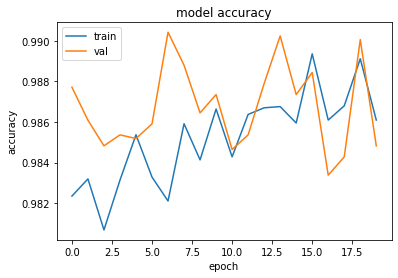

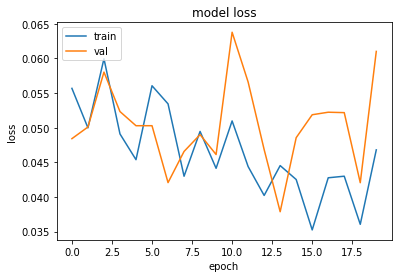

In [9]:
print(model.summary())

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()